In [1]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import torch.nn as nn  
import torch.nn.functional as F
import torch.nn.init as init


class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)
def _weights_init(m):
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)
        
class ResNet_ImageNet(nn.Module):
    def __init__(self, block, num_blocks, pretrained=False, norm=False, Embed=True, feat_dim=512, embed_dim=512,num_classes=10):
        super(ResNet_ImageNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.last = nn.Linear(512,num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, pen=False):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        if pen:
            return out
        else:
            out = self.last(out)
            return out
            
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
        
def resnet18_ImageNet(out_dim):
    return ResNet_ImageNet(BasicBlock, [2, 2, 2, 2], num_classes=out_dim)
  


In [2]:
# extract confusion matrix
imnet20_lwf_model='/home/minsoo/workspace/AlwaysBeDreaming-DFCIL/yujin/ImageNet-100/resnet18_DFCIL-twentytask/ImageNet-100/lwf/models/repeat-1/task-20/class.pth'
imnet20_abd_model='/home/minsoo/workspace/AlwaysBeDreaming-DFCIL/yujin/ImageNet-100/resnet18_DFCIL-twentytask/ImageNet-100/abd/models/repeat-1/task-20/class.pth'
imnet20_deepinv_model='/home/minsoo/workspace/AlwaysBeDreaming-DFCIL/yujin/ImageNet-100/resnet18_DFCIL-twentytask/ImageNet-100/deepinv/models/repeat-1/task-20/class.pth'
# imnet5t_lwf_model='/home/minsoo/workspace/AlwaysBeDreaming-DFCIL/yujin/ImageNet-100/resnet18_DFCIL-fivetask/ImageNet-100/lwf/models/repeat-1/task-5/class.pth'
# imnet5t_abd_model='/home/minsoo/workspace/AlwaysBeDreaming-DFCIL/yujin/ImageNet-100/resnet18_DFCIL-fivetask/ImageNet-100/abd/models/repeat-1/task-5/class.pth'
# imnet5_deepinv_model='/home/minsoo/workspace/AlwaysBeDreaming-DFCIL/yujin/ImageNet-100/resnet18_DFCIL-fivetask/ImageNet-100/deepinv/models/repeat-1/task-5/class.pth'
model_paths=[imnet20_lwf_model,imnet20_deepinv_model,imnet20_abd_model]
# model_paths=[imnet5t_lwf_model,imnet5_deepinv_model,imnet5t_abd_model]
import sys
sys.path.append('..')

models=[]
for mp in model_paths:
    m = resnet18_ImageNet(100)
    # m = torch.nn.DataParallel(m)
    m.load_state_dict(torch.load(mp))
    m.eval()
    models.append(m)

In [3]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
import sys
sys.path.append('../')
import dataloaders
from torch.utils.data import DataLoader


Dataset = dataloaders.iIMAGENET
num_classes = 100
dataset_size = [224,224,3]
dataroot=os.path.join('/data','shared')
# dataroot=os.path.join('/data')
dataset='ImageNet'
seed=0
max_task = 20
first_split_size=num_classes//max_task
other_split_size=num_classes//max_task
i=max_task-1 # incremental class
# load tasks
class_order = np.arange(num_classes).tolist()
class_order_logits = np.arange(num_classes).tolist()
rand_split = True
if rand_split:
    print('=============================================')
    print('Shuffling....')
    print('pre-shuffle:' + str(class_order))
    if dataset == 'ImageNet':
        np.random.seed(1993)
        np.random.shuffle(class_order)
    else:
        random.seed(seed)
        random.shuffle(class_order)
    print('post-shuffle:' + str(class_order))
    print('=============================================')
tasks = []
tasks_logits = []
p = 0
dataset='ImageNet'

while p < num_classes and (max_task == -1 or len(tasks) < max_task):
    inc = other_split_size if p > 0 else first_split_size
    tasks.append(class_order[p:p+inc])
    tasks_logits.append(class_order_logits[p:p+inc])
    p += inc
num_tasks = len(tasks)
task_names = [str(i+1) for i in range(num_tasks)]

# number of tasks to perform
if max_task > 0:
    max_task = min(max_task, len(task_names))
else:
    max_task = len(task_names)

# datasets and dataloaders
test_transform  = dataloaders.utils.get_transform(dataset=dataset, phase='test', aug=False, dgr=False)
test_dataset  = Dataset(dataroot, train=False, tasks=tasks,
                        download_flag=False, transform=test_transform, 
                        seed=0, validation=False)
# learn
test_dataset.load_dataset(i, train=False)
# load dataloader
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, drop_last=False, num_workers=2)
def save_confusion_matrix(y_pred, y_true, name):
    y_true=torch.cat(y_true, dim=0).cpu()
    y_pred=torch.cat(y_pred, dim=0).cpu()
    cm = confusion_matrix(y_true, y_pred)
    if cm.shape[0]<num_classes:
        cm1 = np.pad(cm, ((0,num_classes-cm.shape[0]),(0,num_classes-cm.shape[1])), 'constant', constant_values=0)
    else:
        cm1=cm
    np.save(os.path.join('confusion_matrix_imnet',name+'_{}task_confusion_matrix.npy'.format(max_task)), cm1)
    return cm1


Shuffling....
pre-shuffle:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
post-shuffle:[68, 56, 78, 8, 23, 84, 90, 65, 74, 76, 40, 89, 3, 92, 55, 9, 26, 80, 43, 38, 58, 70, 77, 1, 85, 19, 17, 50, 28, 53, 13, 81, 45, 82, 6, 59, 83, 16, 15, 44, 91, 41, 72, 60, 79, 52, 20, 10, 31, 54, 37, 95, 14, 71, 96, 98, 97, 2, 64, 66, 42, 22, 35, 86, 24, 34, 87, 21, 99, 0, 88, 27, 18, 94, 11, 12, 47, 25, 30, 46, 62, 69, 36, 61, 7, 63, 75, 5, 32, 4, 51, 48, 73, 93, 39, 67, 29, 49, 57, 33]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58

In [4]:

num_tasks = max_task
names = ['lwf','deepinv','abd']
confs=[]
i=0
for name, model in zip(names, models):
    # i+=1
    # if i==1 or i==2:
    #     continue
    y_true=[]
    y_pred=[]
    model.cuda()
    for data in test_loader:
        x, y, t = data
        x = x.cuda()
        y = y.cuda()
        # y = mapping_tensor[y]
        # y = [class_order.index(i) for i in y.tolist()]
        # y = torch.tensor(y).cuda()
        with torch.no_grad():
            logits = model(x)
        # print(logits.argmax(dim=1))
        y_pred.append(logits.argmax(dim=1).detach().cpu())
        y_true.append(y.cpu())
        # print(y_pred[-1],y_true[-1])
    print( (torch.cat(y_pred,dim=0) == torch.cat(y_true,dim=0)).sum()/len(test_loader.dataset))
    # y_pred= torch.cat(y_pred,dim=0)
    # y_true= torch.cat(y_true,dim=0)
    conf = save_confusion_matrix(y_pred,y_true,name)
    torch.cuda.empty_cache()
    confs.append(conf)
    print(name,' Done')
    

tensor(0.0138)
lwf  Done
tensor(0.0518)
deepinv  Done
tensor(0.1632)
abd  Done


In [5]:
import numpy as np

# imnet 100 10task
ours_path = '/home/minsoo/workspace/AlwaysBeDreaming-DFCIL/yujin/ImageNet-100/version_451_imnet_10task_45.18/ours_10task_confusion_matrix.npy'
rdfcil_path='/home/minsoo/workspace/AlwaysBeDreaming-DFCIL/yujin/ImageNet-100/imnet100_version_430_rdfcil_10task_40.7/rdfcil_10task_confusion_matrix.npy'

# imnet-1k
# ours_path='/home/minsoo/workspace/AlwaysBeDreaming-DFCIL/yujin/ours_imagenet1000_5task_confusion_matrix.npy'
# rdfcil_path='/home/minsoo/workspace/AlwaysBeDreaming-DFCIL/yujin/rdfcil_imagenet1000_5task_confusion_matrix.npy'
ours_mat= np.load(ours_path)
rdfcil_mat=np.load(rdfcil_path)

In [6]:
confs=confs[:3]
print(len(confs))
confs.extend([rdfcil_mat,ours_mat])

3


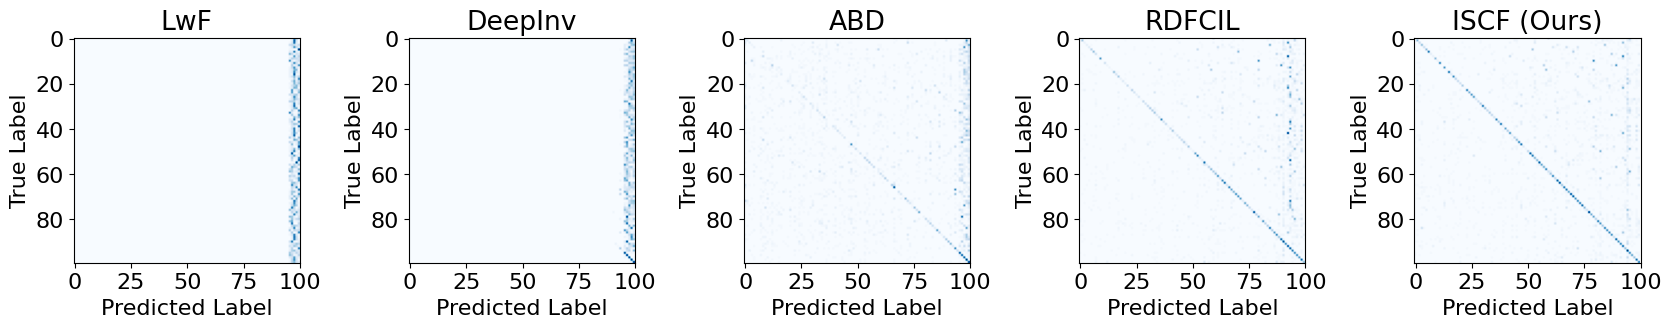

In [8]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, axs = plt.subplots(1, 5, figsize=(17, 5))
# font size
plt.rcParams.update({'font.size': 16})
# axis font
plt.rcParams.update({'axes.labelsize': 16})
# fig.suptitle('Confusion Matrices')
names=['LwF','DeepInv', 'ABD', 'RDFCIL', 'ISCF (Ours)']
for i, (name,conf) in enumerate(zip(names,confs)):
    axs[i].imshow(conf, cmap='Blues')
    axs[i].set_title('{}'.format(name))
    axs[i].set_xlabel('Predicted Label')
    axs[i].set_ylabel('True Label')
    axs[i].set_xticks(np.arange(0, 101, 25))
# Adjust the spacing between subplots
plt.tight_layout()
# Display the subplots
plt.savefig('imnet_{}t_confusion_matrices.pdf'.format(max_task), bbox_inches='tight')
plt.show()
plt.cla()
plt.clf()
plt.close()
    